In [7]:
import enum
from dataclasses import dataclass, field
from copy import deepcopy
import torch_geometric.data as gd

import torch_geometric 
import matplotlib
print("torch_geometric\t", torch_geometric.__version__)
print("matplotlib\t", matplotlib.__version__)

torch_geometric	 2.3.1
matplotlib	 3.7.1


# State & Action Spaces


**State space**

- A state is simply a graph with node types and edge types
- We define initial state as a graph with one node.

**Action space**

- AddNode: add a new node
- AddEdge: add a new edge
- Stop: end the episode

In [2]:
class NodeType(enum.Enum):
    C = enum.auto()
    N = enum.auto()
    O = enum.auto()
    S = enum.auto()
    P = enum.auto()
    F = enum.auto()
    I = enum.auto()
    Cl = enum.auto()
    Br = enum.auto()



class EdgeType(enum.Enum):
    SINGLE = enum.auto()
    DOUBLE = enum.auto()
    TRIPLE = enum.auto()

    

class ActionType(enum.Enum):
    AddNode = enum.auto()
    AddEdge = enum.auto()
    STOP = enum.auto()
        
        
@dataclass
class State:
    node_types: list[NodeType] = field(default_factory=list)
    edge_types: list[EdgeType] = field(default_factory=list)
    edge_list: list[tuple[int, int]] = field(default_factory=list)

    num_node: int = field(default_factory=int, repr=False)
    num_edge: int = field(default_factory=int, repr=False)
    _edge_set: set[tuple[int, int]] = field(default_factory=set, repr=False)
        
    def __post_init__(self):
        self.num_node = len(self.node_types)
        self.num_edges = len(self.edge_types)
        self._edge_set = set(self.edge_list)

    def add_node(self, node_type: NodeType):
        self.node_types.append(node_type)
        self.num_node += 1

    def add_edge(self, i: int, j: int, edge_type: EdgeType):
        edge = (i, j) if i < j else (j, i)
        self.edge_types.append(edge_type)
        self.edge_list.append(edge)
        self._edge_set.add(edge)
        self.num_edge += 1
        
@dataclass
class Action:
    type: ActionType = None
    source: int = None
    target: int = None
    node_type: NodeType = None
    edge_type: EdgeType = None

# Environment

In [3]:

class Environment:
    def __init__(self, num_node_types: int, num_edge_types: int):
        self.num_node_types = num_node_types
        self.num_edge_types = num_edge_types

    def initial_state(self):
        return State([NodeType.C])

    def step(self, state: State, action: Action):
        next_state, done = deepcopy(state), False

        if action.type == ActionType.AddNode:
            next_state.add_node(action.node_type)

        elif action.type == ActionType.AddEdge:
            next_state.add_edge(action.source, action.target, action.edge_type)

        else:
            done = True

        return next_state, done
    
    def to_Data(self, state: State) -> gd.Data:
        # edge_index
        edge_index = (
            torch.LongTensor(
                [e for i, j in state.edge_list for e in [(i, j), (j, i)]],
            )
            .reshape(-1, 2)
            .t()
            .contiguous()
        )

        # types
        node_type = torch.LongTensor([n.value for n in state.node_types]) - 1
        edge_type = (
            torch.LongTensor([e for n in state.edge_types for e in (n.value, n.value)])
            - 1
        )

        # non_edge_index
        non_edges = state.get_non_edge_list()
        non_edge_index = torch.LongTensor(non_edges).reshape(-1, 2).t().contiguous()
        num_non_edges = non_edge_index.shape[1]

        return gd.Data(
            edge_index=edge_index,
            non_edge_index=non_edge_index,
            node_type=node_type,
            edge_type=edge_type,
            num_non_edges=num_non_edges,
        )
    
    
env = Environment(len(NodeType), len(EdgeType))

env.initial_state()

State(node_types=[<NodeType.C: 1>], edge_types=[], edge_list=[])

In [4]:
actions = [
    Action(type=ActionType.AddNode, node_type=NodeType.C),
    Action(type=ActionType.AddNode, node_type=NodeType.C),
    Action(type=ActionType.AddNode, node_type=NodeType.C),
    Action(type=ActionType.AddEdge, source=0, target= 1, edge_type=EdgeType.SINGLE),
    Action(type=ActionType.AddEdge, source=1, target= 2, edge_type=EdgeType.SINGLE),
    Action(type=ActionType.AddEdge, source=3, target= 1, edge_type=EdgeType.SINGLE),
    Action(type=ActionType.STOP)
]

state = env.initial_state()
for action in actions:
    state, *_ = env.step(state, action)
    
state

State(node_types=[<NodeType.C: 1>, <NodeType.C: 1>, <NodeType.C: 1>, <NodeType.C: 1>], edge_types=[<EdgeType.SINGLE: 1>, <EdgeType.SINGLE: 1>, <EdgeType.SINGLE: 1>], edge_list=[(0, 1), (1, 2), (1, 3)])

You can see the full implementations in `environment.py`.

In [8]:
from envs import Environment

env = Environment()

caffeine = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
state = env.State.from_smiles(caffeine)
state

State(node_types=[C, N, C, N, C, C, C, O, N, C, O, N, C, C], edge_types=[SINGLE, SINGLE, DOUBLE, SINGLE, DOUBLE, SINGLE, DOUBLE, SINGLE, SINGLE, DOUBLE, SINGLE, SINGLE, SINGLE, SINGLE, SINGLE], edge_list=[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (6, 8), (8, 9), (9, 10), (9, 11), (11, 12), (8, 13), (5, 1), (11, 4)])

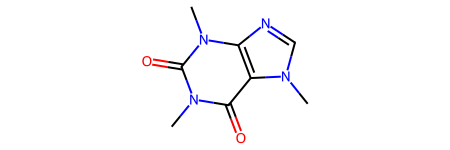

In [9]:
state.to_mol()

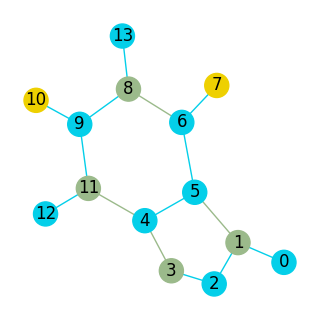

In [10]:
state.viz()

In [11]:
states, actions = env.get_bfs_trajectory(state)

In [12]:
states[:6]

[State(node_types=[C], edge_types=[], edge_list=[]),
 State(node_types=[C, N], edge_types=[], edge_list=[]),
 State(node_types=[C, N], edge_types=[SINGLE], edge_list=[(0, 1)]),
 State(node_types=[C, N, C], edge_types=[SINGLE], edge_list=[(0, 1)]),
 State(node_types=[C, N, C], edge_types=[SINGLE, SINGLE], edge_list=[(0, 1), (1, 2)]),
 State(node_types=[C, N, C, C], edge_types=[SINGLE, SINGLE], edge_list=[(0, 1), (1, 2)])]

# Question

1. 위에서는 가상의 노드를 추가하여 edge를 선택하는 방식으로 action space를 정의하였다. \
    만약 node type이 여러 개인 경우 action을 어떻게 정의할 수 있을까?
    
2. `to_Data` 함수에서 `edge_index`를 만들 때 `.contiguous()` 메소드를 사용했는데, 그 역할은?